In [1]:
!nvidia-smi

Tue Oct 10 22:07:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P0              17W /  95W |      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
from torch import nn
from torch.nn import functional as F
import torch
from torch import optim
from torchvision import datasets,transforms
from torchinfo import summary

In [3]:
from transformations import train_transforms,test_transforms

In [4]:
from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer

In [5]:
# ALbumentation
train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)

cifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
train_loader,test_loader = cifar.get_loader(train_dataset,test_dataset)

In [6]:
# cifar = CIFAR10DataLoader()
# simple_train_loader , simple_test_loader = cifar.get_loader(
#     CIFAR10Dataset(root='../data/',train=True,Atransforms=test_transforms,download=False),
#     CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
# )

In [7]:
# We used this Squeeze-Expand Network before
class Net3(nn.Module):
    def __init__(self):
        super(Net3,self).__init__()
        self.dp_rate = 0.1

        self.c1 = ConvLayer(inc=3,outc=16,s=1,k=3,p=1,d=1,dp_rate=self.dp_rate)
        self.c2 = ConvLayer(inc=16,outc=16,s=1,p=1,k=3,d=1,dp_rate=self.dp_rate)
        self.c3 = ConvLayer(inc=16,outc=32,s=2,p=1,d=1,k=3,dp_rate=self.dp_rate)


        self.dilated1 = DepthwiseConvLayer(inc=32,outc=32,k=3,s=1,p=1,dp_rate=self.dp_rate)
        
        self.c4 = ConvLayer(inc=32,outc=40,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c5 = ConvLayer(inc=40,outc=40,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c6 = ConvLayer(inc=40,outc=40,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate)

        self.dilated2 = DepthwiseConvLayer(inc=40,outc=40,k=3,s=1,p=1,dp_rate=self.dp_rate)

        
        self.c7 = ConvLayer(inc=40,outc=80,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c8 = ConvLayer(inc=80,outc=80,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c9 = nn.Sequential(
            nn.Conv2d(in_channels=80,out_channels=70,kernel_size=3,stride=2,dilation=1,padding=1,bias=False)
        )
        
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.c10 = nn.Conv2d(70,10,kernel_size=1,bias=False)


        
    def forward(self,x):
        x = self.c1(x)
        x = x + self.c2(x)
        x = self.c3(x)

        x = F.dropout2d(
                    F.relu_( 
                        F.batch_norm(
                            self.dilated1(x),
                            torch.zeros(32,device=device),  # mu=0
                            torch.ones(32,device=device),   # ones are fine for first training iter  
                            training=True,
                            momentum=0.9
                        )
                    ),p=0.1
                )
        
        
        
        x = self.c4(x)
        x = x+self.c5(x)
        x = self.c6(x)

        # x =  F.dropout2d(
        #             F.relu_( 
        #                 F.batch_norm(
        #                     self.dilated2(x),
        #                     torch.zeros(40,device=device),  # mu=0
        #                     torch.ones(40,device=device),   # ones are fine for first training iter  
        #                     training=True,
        #                     momentum=0.9
        #                 )
        #             ),p=0.1
        #         )
        
        
        
        
        x = self.c7(x)
        x = x + self.c8(x)
        x = self.c9(x)

        x = self.gap(x)
        x = self.c10(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [8]:
model2 = Net3().to(device)
summary(model2,(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Net3                                     [1, 10]                   1,960
├─ConvLayer: 1-1                         [1, 16, 32, 32]           --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 32, 32]           432
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─ReLU: 3-3                    [1, 16, 32, 32]           --
│    │    └─Dropout2d: 3-4               [1, 16, 32, 32]           --
├─ConvLayer: 1-2                         [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-6             [1, 16, 32, 32]           32
│    │    └─ReLU: 3-7                    [1, 16, 32, 32]           --
│    │    └─Dropout2d: 3-8               [1, 16, 32, 32]           --
├─ConvLa

In [9]:
prev_test_loss = float('inf')

optimizer = optim.SGD(model2.parameters(), lr=0.15, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model2, train_loader, optimizer, criterion, device)
tester = Tester(model2, test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(model2.state_dict(),'./bmodels/simple_model_with_mp_rf44_resnet_dil_depthwise_conv.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.15 | Loss = 1.85 | Batch = 97 | Accuracy = 22.66: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.31it/s]


Test set: Average loss: 0.0036, Accuracy: 3050/10000 (30.50%)


EPOCH = 2 | LR = 0.15 | Loss = 1.83 | Batch = 97 | Accuracy = 31.09: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.56it/s]


Test set: Average loss: 0.0032, Accuracy: 4004/10000 (40.04%)


EPOCH = 3 | LR = 0.15 | Loss = 1.80 | Batch = 97 | Accuracy = 35.85: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.45it/s]


Test set: Average loss: 0.0030, Accuracy: 4266/10000 (42.66%)


EPOCH = 4 | LR = 0.15 | Loss = 1.66 | Batch = 97 | Accuracy = 38.68: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.49it/s]


Test set: Average loss: 0.0029, Accuracy: 4643/10000 (46.43%)


EPOCH = 5 | LR = 0.15 | Loss = 1.53 | Batch = 97 | Accuracy = 41.36: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.53it/s]


Test set: Average loss: 0.0027, Accuracy: 4908/10000 (49.08%)


EPOCH = 6 | LR = 0.15 | Loss = 1.54 | Batch = 97 | Accuracy = 42.99: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.51it/s]


Test set: Average loss: 0.0028, Accuracy: 4854/10000 (48.54%)


EPOCH = 7 | LR = 0.15 | Loss = 1.58 | Batch = 97 | Accuracy = 44.88: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.53it/s]


Test set: Average loss: 0.0025, Accuracy: 5348/10000 (53.48%)


EPOCH = 8 | LR = 0.15 | Loss = 1.49 | Batch = 97 | Accuracy = 46.55: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.51it/s]


Test set: Average loss: 0.0025, Accuracy: 5523/10000 (55.23%)


EPOCH = 9 | LR = 0.15 | Loss = 1.36 | Batch = 97 | Accuracy = 47.57: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.48it/s]


Test set: Average loss: 0.0024, Accuracy: 5760/10000 (57.60%)


EPOCH = 10 | LR = 0.15 | Loss = 1.40 | Batch = 97 | Accuracy = 48.78: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.42it/s]


Test set: Average loss: 0.0022, Accuracy: 5964/10000 (59.64%)


EPOCH = 11 | LR = 0.15 | Loss = 1.35 | Batch = 97 | Accuracy = 50.37: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.39it/s]


Test set: Average loss: 0.0021, Accuracy: 6177/10000 (61.77%)


EPOCH = 12 | LR = 0.15 | Loss = 1.38 | Batch = 97 | Accuracy = 51.37: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.32it/s]


Test set: Average loss: 0.0021, Accuracy: 6225/10000 (62.25%)


EPOCH = 13 | LR = 0.15 | Loss = 1.27 | Batch = 97 | Accuracy = 52.39: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.36it/s]


Test set: Average loss: 0.0020, Accuracy: 6377/10000 (63.77%)


EPOCH = 14 | LR = 0.15 | Loss = 1.35 | Batch = 97 | Accuracy = 53.54: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.41it/s]


Test set: Average loss: 0.0021, Accuracy: 6249/10000 (62.49%)


EPOCH = 15 | LR = 0.15 | Loss = 1.19 | Batch = 97 | Accuracy = 54.10: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.44it/s]


Test set: Average loss: 0.0019, Accuracy: 6549/10000 (65.49%)


EPOCH = 16 | LR = 0.15 | Loss = 1.19 | Batch = 97 | Accuracy = 55.23: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.17it/s]


Test set: Average loss: 0.0019, Accuracy: 6653/10000 (66.53%)


EPOCH = 17 | LR = 0.15 | Loss = 1.22 | Batch = 97 | Accuracy = 56.46: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.48it/s]


Test set: Average loss: 0.0018, Accuracy: 6793/10000 (67.93%)


EPOCH = 18 | LR = 0.15 | Loss = 1.30 | Batch = 97 | Accuracy = 56.45: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.43it/s]


Test set: Average loss: 0.0018, Accuracy: 6871/10000 (68.71%)


EPOCH = 19 | LR = 0.15 | Loss = 1.15 | Batch = 97 | Accuracy = 57.45: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.46it/s]


Test set: Average loss: 0.0017, Accuracy: 6921/10000 (69.21%)


EPOCH = 20 | LR = 0.15 | Loss = 1.16 | Batch = 97 | Accuracy = 57.56: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.42it/s]


Test set: Average loss: 0.0018, Accuracy: 6924/10000 (69.24%)


EPOCH = 21 | LR = 0.15 | Loss = 1.17 | Batch = 97 | Accuracy = 58.35: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.41it/s]


Test set: Average loss: 0.0017, Accuracy: 7036/10000 (70.36%)


EPOCH = 22 | LR = 0.15 | Loss = 1.24 | Batch = 97 | Accuracy = 58.91: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.45it/s]


Test set: Average loss: 0.0017, Accuracy: 7087/10000 (70.87%)


EPOCH = 23 | LR = 0.15 | Loss = 1.08 | Batch = 97 | Accuracy = 59.32: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.47it/s]


Test set: Average loss: 0.0016, Accuracy: 7188/10000 (71.88%)


EPOCH = 24 | LR = 0.15 | Loss = 1.15 | Batch = 97 | Accuracy = 59.67: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.42it/s]


Test set: Average loss: 0.0016, Accuracy: 7257/10000 (72.57%)


EPOCH = 25 | LR = 0.15 | Loss = 1.26 | Batch = 97 | Accuracy = 59.97: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.35it/s]


Test set: Average loss: 0.0016, Accuracy: 7242/10000 (72.42%)


EPOCH = 26 | LR = 0.15 | Loss = 1.12 | Batch = 97 | Accuracy = 60.13: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.48it/s]


Test set: Average loss: 0.0016, Accuracy: 7210/10000 (72.10%)


EPOCH = 27 | LR = 0.15 | Loss = 1.14 | Batch = 97 | Accuracy = 60.73: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.53it/s]


Test set: Average loss: 0.0015, Accuracy: 7303/10000 (73.03%)


EPOCH = 28 | LR = 0.15 | Loss = 1.02 | Batch = 97 | Accuracy = 60.58: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.42it/s]


Test set: Average loss: 0.0015, Accuracy: 7370/10000 (73.70%)


EPOCH = 29 | LR = 0.15 | Loss = 1.05 | Batch = 97 | Accuracy = 61.20: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.43it/s]


Test set: Average loss: 0.0015, Accuracy: 7382/10000 (73.82%)


EPOCH = 30 | LR = 0.15 | Loss = 0.97 | Batch = 97 | Accuracy = 61.42: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.31it/s]


Test set: Average loss: 0.0015, Accuracy: 7359/10000 (73.59%)


EPOCH = 31 | LR = 0.15 | Loss = 1.18 | Batch = 97 | Accuracy = 61.64: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.43it/s]


Test set: Average loss: 0.0015, Accuracy: 7423/10000 (74.23%)


EPOCH = 32 | LR = 0.15 | Loss = 1.10 | Batch = 97 | Accuracy = 62.10: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.41it/s]


Test set: Average loss: 0.0015, Accuracy: 7469/10000 (74.69%)


EPOCH = 33 | LR = 0.15 | Loss = 1.10 | Batch = 97 | Accuracy = 62.64: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.29it/s]


Test set: Average loss: 0.0015, Accuracy: 7453/10000 (74.53%)


EPOCH = 34 | LR = 0.15 | Loss = 1.08 | Batch = 97 | Accuracy = 62.89: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.38it/s]


Test set: Average loss: 0.0015, Accuracy: 7402/10000 (74.02%)


EPOCH = 35 | LR = 0.15 | Loss = 1.16 | Batch = 97 | Accuracy = 62.77: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.34it/s]


Test set: Average loss: 0.0014, Accuracy: 7553/10000 (75.53%)


EPOCH = 36 | LR = 0.15 | Loss = 1.06 | Batch = 97 | Accuracy = 63.07: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.39it/s]


Test set: Average loss: 0.0014, Accuracy: 7512/10000 (75.12%)


EPOCH = 37 | LR = 0.15 | Loss = 0.98 | Batch = 97 | Accuracy = 63.25: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.40it/s]


Test set: Average loss: 0.0014, Accuracy: 7537/10000 (75.37%)


EPOCH = 38 | LR = 0.15 | Loss = 0.98 | Batch = 97 | Accuracy = 63.38: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.29it/s]


Test set: Average loss: 0.0014, Accuracy: 7592/10000 (75.92%)


EPOCH = 39 | LR = 0.15 | Loss = 0.99 | Batch = 97 | Accuracy = 63.23: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.37it/s]


Test set: Average loss: 0.0014, Accuracy: 7583/10000 (75.83%)


EPOCH = 40 | LR = 0.15 | Loss = 1.08 | Batch = 97 | Accuracy = 63.53: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.51it/s]


Test set: Average loss: 0.0014, Accuracy: 7605/10000 (76.05%)


EPOCH = 41 | LR = 0.15 | Loss = 1.03 | Batch = 97 | Accuracy = 63.64: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.51it/s]


Test set: Average loss: 0.0014, Accuracy: 7646/10000 (76.46%)


EPOCH = 42 | LR = 0.15 | Loss = 0.93 | Batch = 97 | Accuracy = 63.58: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.43it/s]


Test set: Average loss: 0.0014, Accuracy: 7554/10000 (75.54%)


EPOCH = 43 | LR = 0.15 | Loss = 0.97 | Batch = 97 | Accuracy = 64.05: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.38it/s]


Test set: Average loss: 0.0014, Accuracy: 7645/10000 (76.45%)


EPOCH = 44 | LR = 0.15 | Loss = 1.07 | Batch = 97 | Accuracy = 64.44: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.34it/s]


Test set: Average loss: 0.0014, Accuracy: 7596/10000 (75.96%)


EPOCH = 45 | LR = 0.15 | Loss = 1.00 | Batch = 97 | Accuracy = 64.18: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.29it/s]


Test set: Average loss: 0.0013, Accuracy: 7659/10000 (76.59%)


EPOCH = 46 | LR = 0.15 | Loss = 1.04 | Batch = 97 | Accuracy = 64.71: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.35it/s]


Test set: Average loss: 0.0013, Accuracy: 7700/10000 (77.00%)


EPOCH = 47 | LR = 0.15 | Loss = 1.00 | Batch = 97 | Accuracy = 64.58: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.29it/s]


Test set: Average loss: 0.0013, Accuracy: 7693/10000 (76.93%)


EPOCH = 48 | LR = 0.15 | Loss = 1.01 | Batch = 97 | Accuracy = 64.67: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.30it/s]


Test set: Average loss: 0.0014, Accuracy: 7620/10000 (76.20%)


EPOCH = 49 | LR = 0.15 | Loss = 0.97 | Batch = 97 | Accuracy = 64.96: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.27it/s]


Test set: Average loss: 0.0013, Accuracy: 7722/10000 (77.22%)


EPOCH = 50 | LR = 0.15 | Loss = 0.89 | Batch = 97 | Accuracy = 65.13: 100%|██████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.32it/s]


Test set: Average loss: 0.0013, Accuracy: 7679/10000 (76.79%)


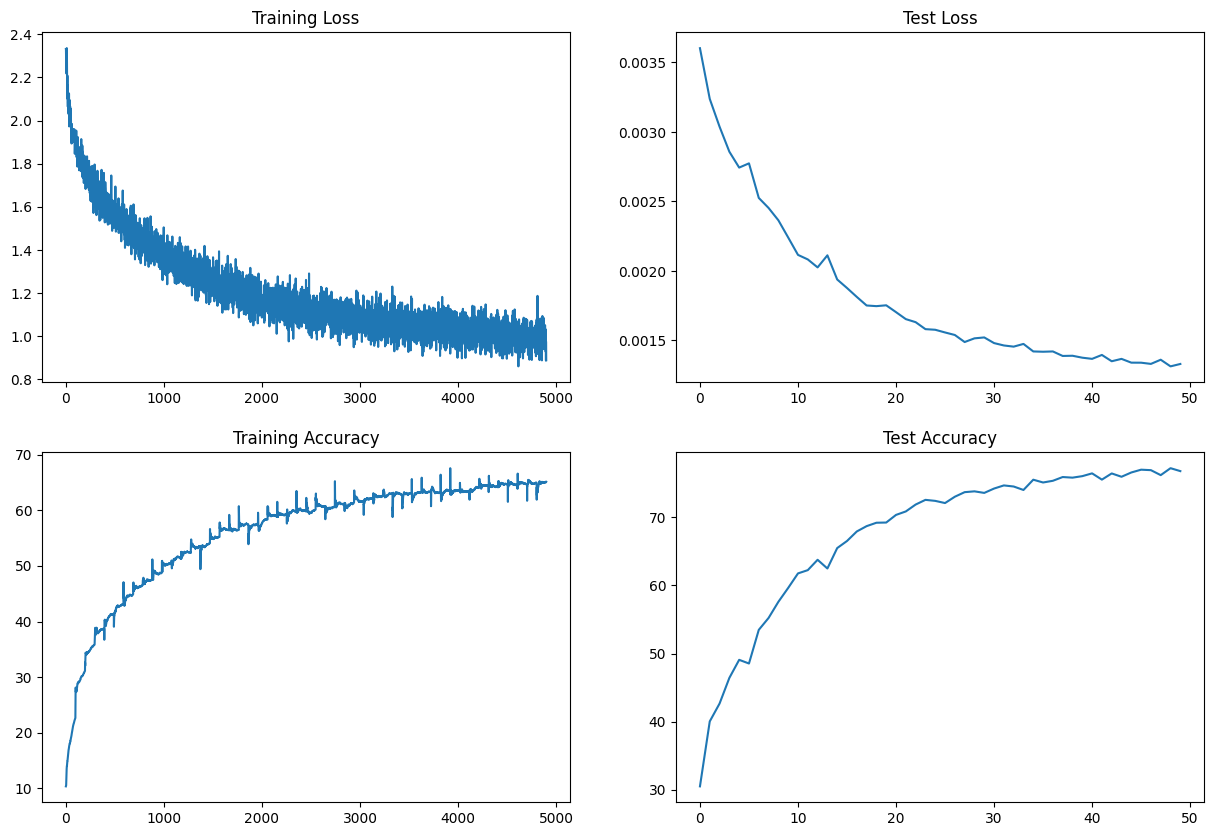

In [10]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Dilated Kernels implementation

In [11]:
class Net(nn.Module):
    def __init__(self,dp_rate):
        super(Net,self).__init__()
        self.dp_rate = dp_rate
        
        self.c1 = nn.Sequential(
            ConvLayer(inc=3,outc=14,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=14,outc=14,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=14,outc=16,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
        )

        self.c2 = nn.Sequential(
            ConvLayer(inc=16,outc=28,k=3,p=1,d=1,s=1,dp_rate=self.dp_rate),
            ConvLayer(inc=28,outc=28,k=3,p=0,s=1,d=1,dp_rate=self.dp_rate)
        )
        self.c3DiL = nn.Sequential(
            ConvLayer(inc=16,outc=28,s=1,p=1,d=2,k=3,dp_rate=self.dp_rate),
        )


        self.c4 = nn.Sequential(
            ConvLayer(inc=28,outc=32,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=32,outc=32,k=3,p=0,s=1,d=1,dp_rate=self.dp_rate),
        )


        self.c5DiL = nn.Sequential(
            ConvLayer(inc=28,outc=32,k=3,d=2,p=1,dp_rate=self.dp_rate,s=1)
        )

        self.c6 = nn.Sequential(
            ConvLayer(inc=32,outc=38,k=3,p=0,dp_rate=self.dp_rate,s=1,d=1),
            ConvLayer(inc=38,outc=42,k=3,p=0,dp_rate=self.dp_rate,s=1,d=1),
            ConvLayer(inc=42,outc=52,k=3,p=0,dp_rate=self.dp_rate,s=1,d=1),
            ConvLayer(inc=52,outc=60,k=3,p=0,dp_rate=self.dp_rate,s=1,d=1)
        )

        self.C7DiL = nn.Sequential(
            ConvLayer(inc=32,outc=36,k=3,p=1,dp_rate=self.dp_rate,s=1,d=2),
            ConvLayer(inc=36,outc=42,k=3,p=1,dp_rate=self.dp_rate,s=1,d=2),
            ConvLayer(inc=42,outc=52,k=3,p=1,dp_rate=self.dp_rate,s=1,d=2),
            ConvLayer(inc=52,outc=60,k=3,p=1,dp_rate=self.dp_rate,s=1,d=2)
        )

        self.dilated = DepthwiseConvLayer(inc=28,outc=28,k=3,s=1,p=1,dp_rate=self.dp_rate)

        
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Conv2d(in_channels=60,out_channels=10,kernel_size=1,bias=False)
    
    def forward(self,x):

        # BLOCK ONE
        x = self.c1(x)
        path1 = self.c2(x)
        path2 = F.dropout2d(
                    F.relu_( 
                        F.batch_norm(
                            self.c3DiL(x),
                            torch.zeros(28,device=device), #mu=0
                            torch.ones(28,device=device),   # ones are fine for first training iter  
                            training=True,
                            momentum=0.9
                        )
                    ),p=0.1 # self.c3DiL(x)
                )
        x = path1 + path2

        x = self.dilated(x)
        
        # BLOCK TWO
        path1 = self.c4(x)
        path2 = F.dropout2d(
                    F.relu_( 
                        F.batch_norm(
                            self.c5DiL(x),
                            torch.zeros(32,device=device), #mu=0
                            torch.ones(32,device=device),   # ones are fine for first training iter  
                            training=True,
                            momentum=0.9
                        )
                    ),p=0.1 # self.c3DiL(x)
                )
        x = path1+path2

        # BLOCK 4
        path1 = self.c6(x)
        path2  =F.dropout2d(
                    F.relu_( 
                        F.batch_norm(
                            self.C7DiL(x),
                            torch.zeros(60,device=device), #mu=0
                            torch.ones(60,device=device),   # ones are fine for first training iter  
                            training=True,
                            momentum=0.9
                        )
                    ),p=0.1 # self.c3DiL(x)
                )

        
        x = path1 + path2

        # GAP
        x = self.gap(x)

        # OUT BLOCK
        x = self.out(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [12]:
model3 = Net(0.2).to(device)
summary(model3,(1,3,32,32),)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 32, 32]           --
│    └─ConvLayer: 2-1                    [1, 14, 32, 32]           --
│    │    └─Sequential: 3-1              [1, 14, 32, 32]           406
│    └─ConvLayer: 2-2                    [1, 14, 32, 32]           --
│    │    └─Sequential: 3-2              [1, 14, 32, 32]           1,792
│    └─ConvLayer: 2-3                    [1, 16, 32, 32]           --
│    │    └─Sequential: 3-3              [1, 16, 32, 32]           2,048
├─Sequential: 1-2                        [1, 28, 30, 30]           --
│    └─ConvLayer: 2-4                    [1, 28, 32, 32]           --
│    │    └─Sequential: 3-4              [1, 28, 32, 32]           4,088
│    └─ConvLayer: 2-5                    [1, 28, 30, 30]           --
│    │    └─Sequential: 3-5              [1, 28, 30, 30]           7,112
├─

In [13]:
prev_test_loss = float('inf')


optimizer = optim.SGD(model3.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(model3, train_loader, optimizer, criterion, device)
tester = Tester(model3, test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(model3.state_dict(),'./bmodels/simple_model_with_mp_rf44_resnet_with_dilation_kernel.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 2.06 | Batch = 97 | Accuracy = 18.19: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:49<00:00,  1.97it/s]


Test set: Average loss: 0.0039, Accuracy: 2770/10000 (27.70%)


EPOCH = 2 | LR = 0.1 | Loss = 2.06 | Batch = 97 | Accuracy = 23.59: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:49<00:00,  1.97it/s]


Test set: Average loss: 0.0037, Accuracy: 3069/10000 (30.69%)


EPOCH = 3 | LR = 0.1 | Loss = 1.92 | Batch = 97 | Accuracy = 25.66: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.96it/s]


Test set: Average loss: 0.0036, Accuracy: 3287/10000 (32.87%)


EPOCH = 4 | LR = 0.1 | Loss = 1.93 | Batch = 97 | Accuracy = 27.16: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:49<00:00,  1.99it/s]


Test set: Average loss: 0.0035, Accuracy: 3437/10000 (34.37%)


EPOCH = 5 | LR = 0.1 | Loss = 1.91 | Batch = 97 | Accuracy = 28.82: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:49<00:00,  1.96it/s]


Test set: Average loss: 0.0034, Accuracy: 3708/10000 (37.08%)


EPOCH = 6 | LR = 0.1 | Loss = 1.91 | Batch = 97 | Accuracy = 30.30: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:49<00:00,  1.97it/s]


Test set: Average loss: 0.0033, Accuracy: 3863/10000 (38.63%)


EPOCH = 7 | LR = 0.1 | Loss = 1.84 | Batch = 97 | Accuracy = 31.39: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:49<00:00,  1.99it/s]


Test set: Average loss: 0.0032, Accuracy: 4001/10000 (40.01%)


EPOCH = 8 | LR = 0.1 | Loss = 1.79 | Batch = 97 | Accuracy = 32.64: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.89it/s]


Test set: Average loss: 0.0032, Accuracy: 4113/10000 (41.13%)


EPOCH = 9 | LR = 0.1 | Loss = 1.82 | Batch = 97 | Accuracy = 33.63: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.0031, Accuracy: 4228/10000 (42.28%)


EPOCH = 10 | LR = 0.1 | Loss = 1.73 | Batch = 97 | Accuracy = 33.80: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.0031, Accuracy: 4275/10000 (42.75%)


EPOCH = 11 | LR = 0.1 | Loss = 1.65 | Batch = 97 | Accuracy = 35.25: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.96it/s]


Test set: Average loss: 0.0030, Accuracy: 4435/10000 (44.35%)


EPOCH = 12 | LR = 0.1 | Loss = 1.73 | Batch = 97 | Accuracy = 35.73: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.0030, Accuracy: 4512/10000 (45.12%)


EPOCH = 13 | LR = 0.1 | Loss = 1.80 | Batch = 97 | Accuracy = 35.91: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.0029, Accuracy: 4526/10000 (45.26%)


EPOCH = 14 | LR = 0.1 | Loss = 1.60 | Batch = 97 | Accuracy = 36.85: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.91it/s]


Test set: Average loss: 0.0028, Accuracy: 4711/10000 (47.11%)


EPOCH = 15 | LR = 0.1 | Loss = 1.63 | Batch = 97 | Accuracy = 37.42: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.91it/s]


Test set: Average loss: 0.0028, Accuracy: 4864/10000 (48.64%)


EPOCH = 16 | LR = 0.1 | Loss = 1.70 | Batch = 97 | Accuracy = 38.12: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.93it/s]


Test set: Average loss: 0.0028, Accuracy: 4849/10000 (48.49%)


EPOCH = 17 | LR = 0.1 | Loss = 1.64 | Batch = 97 | Accuracy = 38.82: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.93it/s]


Test set: Average loss: 0.0027, Accuracy: 5022/10000 (50.22%)


EPOCH = 18 | LR = 0.1 | Loss = 1.67 | Batch = 97 | Accuracy = 39.35: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.88it/s]


Test set: Average loss: 0.0027, Accuracy: 5083/10000 (50.83%)


EPOCH = 19 | LR = 0.1 | Loss = 1.63 | Batch = 97 | Accuracy = 40.39: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.93it/s]


Test set: Average loss: 0.0026, Accuracy: 5080/10000 (50.80%)


EPOCH = 20 | LR = 0.1 | Loss = 1.55 | Batch = 97 | Accuracy = 41.07: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.93it/s]


Test set: Average loss: 0.0026, Accuracy: 5324/10000 (53.24%)


EPOCH = 21 | LR = 0.1 | Loss = 1.65 | Batch = 97 | Accuracy = 41.51: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.91it/s]


Test set: Average loss: 0.0026, Accuracy: 5204/10000 (52.04%)


EPOCH = 22 | LR = 0.1 | Loss = 1.56 | Batch = 97 | Accuracy = 41.74: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.94it/s]


Test set: Average loss: 0.0025, Accuracy: 5409/10000 (54.09%)


EPOCH = 23 | LR = 0.1 | Loss = 1.55 | Batch = 97 | Accuracy = 42.68: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.0024, Accuracy: 5538/10000 (55.38%)


EPOCH = 24 | LR = 0.1 | Loss = 1.54 | Batch = 97 | Accuracy = 42.92: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.96it/s]


Test set: Average loss: 0.0024, Accuracy: 5517/10000 (55.17%)


EPOCH = 25 | LR = 0.1 | Loss = 1.56 | Batch = 97 | Accuracy = 43.23: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.0024, Accuracy: 5580/10000 (55.80%)


EPOCH = 26 | LR = 0.1 | Loss = 1.55 | Batch = 97 | Accuracy = 44.07: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.0024, Accuracy: 5622/10000 (56.22%)


EPOCH = 27 | LR = 0.1 | Loss = 1.52 | Batch = 97 | Accuracy = 44.10: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.95it/s]


Test set: Average loss: 0.0024, Accuracy: 5720/10000 (57.20%)


EPOCH = 28 | LR = 0.1 | Loss = 1.50 | Batch = 97 | Accuracy = 44.66: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Test set: Average loss: 0.0023, Accuracy: 5745/10000 (57.45%)


EPOCH = 29 | LR = 0.1 | Loss = 1.47 | Batch = 97 | Accuracy = 45.08: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.90it/s]


Test set: Average loss: 0.0023, Accuracy: 5784/10000 (57.84%)


EPOCH = 30 | LR = 0.1 | Loss = 1.56 | Batch = 97 | Accuracy = 45.61: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Test set: Average loss: 0.0023, Accuracy: 5795/10000 (57.95%)


EPOCH = 31 | LR = 0.1 | Loss = 1.44 | Batch = 97 | Accuracy = 45.88: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.88it/s]


Test set: Average loss: 0.0023, Accuracy: 5859/10000 (58.59%)


EPOCH = 32 | LR = 0.1 | Loss = 1.55 | Batch = 97 | Accuracy = 46.32: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 0.0022, Accuracy: 5925/10000 (59.25%)


EPOCH = 33 | LR = 0.1 | Loss = 1.46 | Batch = 97 | Accuracy = 46.54: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.93it/s]


Test set: Average loss: 0.0022, Accuracy: 6062/10000 (60.62%)


EPOCH = 34 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 47.21: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.93it/s]


Test set: Average loss: 0.0022, Accuracy: 6021/10000 (60.21%)


EPOCH = 35 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 47.19: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.94it/s]


Test set: Average loss: 0.0022, Accuracy: 6024/10000 (60.24%)


EPOCH = 36 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 47.42: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.92it/s]


Test set: Average loss: 0.0021, Accuracy: 6157/10000 (61.57%)


EPOCH = 37 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 47.71: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.93it/s]


Test set: Average loss: 0.0021, Accuracy: 6245/10000 (62.45%)


  0%|                                                                                                                                             | 0/98 [00:15<?, ?it/s]

KeyboardInterrupt



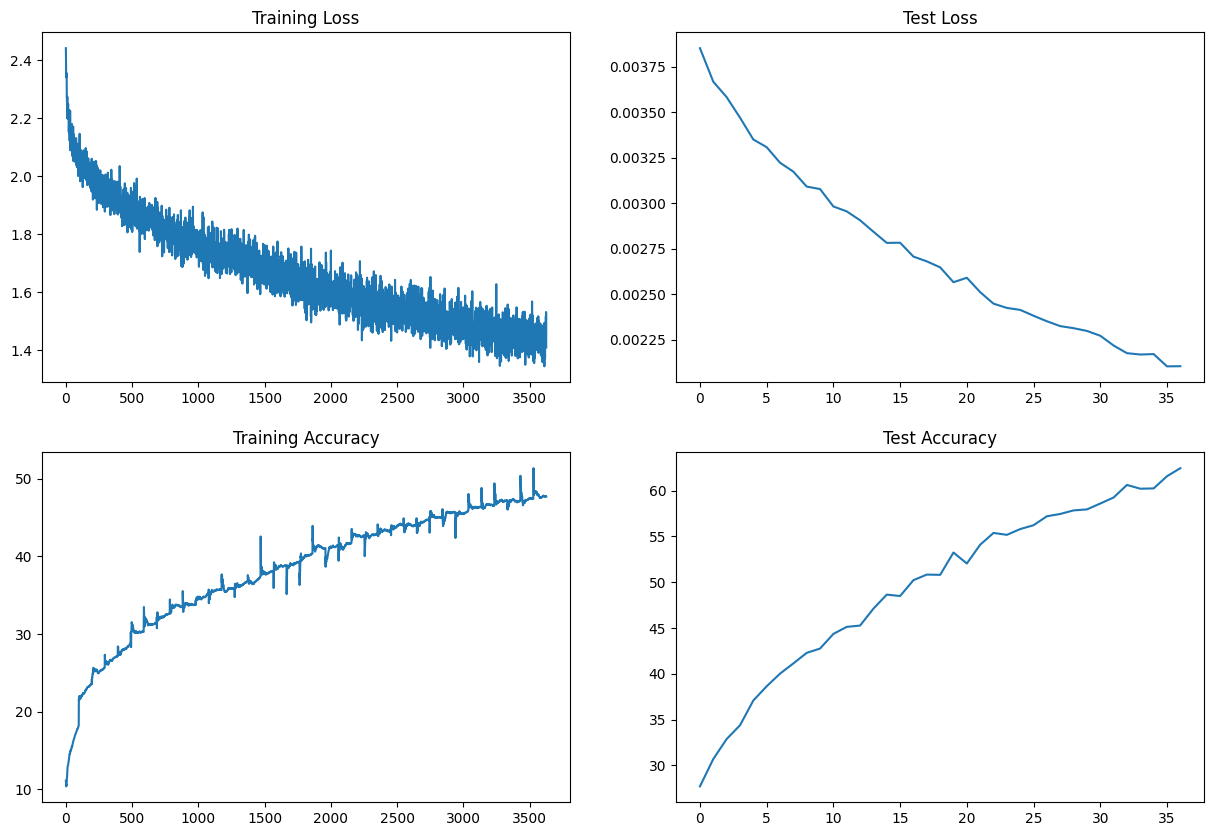

In [14]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

In [ ]:
model4 = Net(0.2).to(device)
summary(model4,(1,3,32,32),)


prev_test_loss = float('inf')


optimizer = optim.SGD(model4.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(model4, train_loader, optimizer, criterion, device)
tester = Tester(model4, test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(model3.state_dict(),'./bmodels/simple_model_with_mp_rf44_resnet_with_dilation_kernel_aug.pth')
    scheduler.step(test_loss)

In [ ]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)